In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.ppo import (
    MultiLayerPerceptron, 
    LSTMNetwork, 
    ActorCritic, 
) 

from utils.functions import save_weights, load_config

from train_ppo import train_one_episode, evaluate_one_episode

In [3]:
import gym
import gym_anytrading

In [4]:
import torch.optim as optim
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf 

In [5]:
from typing import Dict
from pandas.core.frame import DataFrame

In [6]:
cfg = load_config("./config.yaml")
cfg

{'env': {'ticker': 'AAPL',
  'interval': '1d',
  'period': '1y',
  'train_prop': 0.8,
  'window_size': 30},
 'ppo': {'actor_critic': {'hidden_dim': 512},
  'hyperparameters': {'epsilon': 0.2,
   'steps': 5,
   'n_exps': 25,
   'print_freq': 10,
   'reward_threshold': 120,
   'gamma': 0.99,
   'lr': 0.0001,
   'episodes': 100,
   'max_actions': 600}}}

In [7]:
args = {
    "tickers": cfg["env"]["ticker"], 
    "interval": cfg["env"]["interval"], 
    "period": cfg["env"]["period"] 
}

df = yf.download(**args)

[*********************100%***********************]  1 of 1 completed


In [8]:
def get_env_args(df: DataFrame, train_prop: float, window_size: int) -> Dict: 

    n = len(df)
    train_size = int(n * train_prop)
    
    args = {
        "train": {
            "frame_bound": (window_size, train_size),
            "window_size": window_size
        }, 
        "test": {
            "frame_bound": (train_size+window_size+1, n),
            "window_size": window_size
        }
    }    

    return args

train_prop = cfg["env"]["train_prop"]   
window_size = cfg["env"]["window_size"]

env_args = get_env_args(df, train_prop, window_size)

env_train = gym.make(id="stocks-v0", df=df, **env_args["train"])
env_test = gym.make(id="stocks-v0", df=df, **env_args["test"])

c:\Users\pemma\OneDrive - GENES\Ensae\S2\RL\Project\rlhf-box2d\env\lib\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (30, 2)
  logger.warn(


c:\Users\pemma\OneDrive - GENES\Ensae\S2\RL\Project\rlhf-box2d\env\lib\site-packages\gym\utils\passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
c:\Users\pemma\OneDrive - GENES\Ensae\S2\RL\Project\rlhf-box2d\env\lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
c:\Users\pemma\OneDrive - GENES\Ensae\S2\RL\Project\rlhf-box2d\env\lib\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
c:\Users\pem

info: {'total_reward': 6.990081787109375, 'total_profit': 0.5711264030953495, 'position': 1}


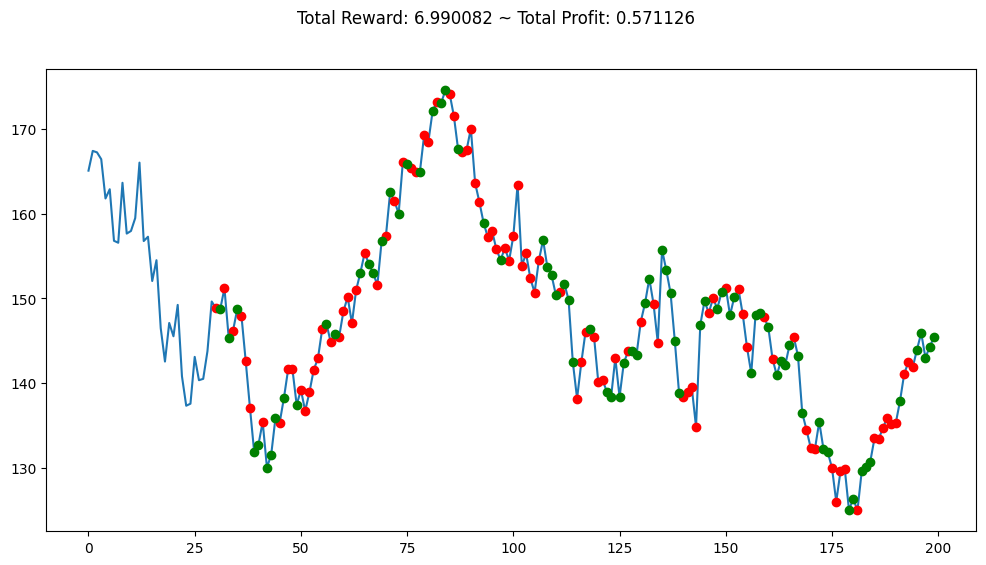

In [9]:
observation = env_train.reset()

while True:
    action = env_train.action_space.sample()
    observation, reward, done, info = env_train.step(action)
    if done:
        print("info:", info)
        break

plt.figure(figsize=(12, 6))
plt.cla()
env_train.render_all()
plt.show(); 

In [10]:
input_dim = env_train.observation_space.shape[0]
hidden_dim = cfg["ppo"]["actor_critic"]["hidden_dim"]
output_dim = env_train.action_space.n

actor = LSTMNetwork(input_dim, hidden_dim, output_dim)
critic = LSTMNetwork(input_dim, hidden_dim, 1)

ppo = ActorCritic(actor, critic)

In [11]:
ppo

ActorCritic(
  (actor): LSTMNetwork(
    (lstm): LSTM(30, 512)
    (fc): Linear(in_features=512, out_features=2, bias=True)
  )
  (critic): LSTMNetwork(
    (lstm): LSTM(30, 512)
    (fc): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [12]:
lr = cfg["ppo"]["hyperparameters"]["lr"]
episodes = cfg["ppo"]["hyperparameters"]["episodes"]
max_actions = cfg["ppo"]["hyperparameters"]["max_actions"]

epsilon = cfg["ppo"]["hyperparameters"]["epsilon"]
steps = cfg["ppo"]["hyperparameters"]["steps"]
n_exps = cfg["ppo"]["hyperparameters"]["n_exps"]
print_freq = cfg["ppo"]["hyperparameters"]["print_freq"]
reward_threshold = cfg["ppo"]["hyperparameters"]["reward_threshold"]
gamma = cfg["ppo"]["hyperparameters"]["gamma"]

In [13]:
optimizer = optim.Adam(ppo.parameters(), lr = lr)

train_rewards = []
test_rewards = []

for episode in range(1, episodes+1):
    
    clip_loss, value_loss, train_reward = train_one_episode(env_train, ppo, optimizer, gamma, steps, epsilon, max_actions)
    test_reward = evaluate_one_episode(env_test, ppo, max_actions)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)

    #get the mean rewards of the last n_exps "experiments"    
    mean_train_rewards = np.mean(train_rewards[-n_exps:])
    mean_test_rewards = np.mean(test_rewards[-n_exps:])

    if episode % print_freq == 0:
        print(f"| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:7.1f} | Mean Test Rewards: {mean_test_rewards:7.1f} |")
    
    if mean_test_rewards >= reward_threshold:
        print(f"Reached reward {str(reward_threshold)} in {episode} episodes")
        save_weights(ppo, f"ppo_{reward_threshold}_{episode}.pt")
        
    if mean_test_rewards >= reward_threshold:
        break

ValueError: too many values to unpack (expected 2)